# TrainGAN
## Approaches to train and test GANs for lifting application

## Abandoned and undocumented due to training difficulties

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
from KITTICat.KITTIBatch import KITTIBatchReader, KITTIValidator
from Models.GAN import *
from Models.Naive import *
import tqdm, torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

g = Naive().to(device)
d = Discriminator().to(device)
# print(g)
trainGLoss = []
trainDLoss = []
valLoss = []
acc = []
iou = []

cuda:0


In [2]:
batchsize = 128

traingen = KITTIBatchReader(batchsize, 'train')
valgen = KITTIBatchReader(batchsize, 'validate')

import torch.optim as optim
import torch.nn as nn
from IPython.display import clear_output

lossFunc = nn.BCELoss()
criteria = nn.MSELoss()
validator = KITTIValidator()
gOptimiser = optim.Adam(g.parameters())
dOptimiser = optim.Adam(d.parameters())

epochs = 10

for epoch in range(epochs):
    clear_output()

    if epoch > 0:
        print(f'Last Epoch ValLoss: {valLoss[-1]:.2E}  Acc: {acc[-1]:.2E}  IOU: {iou[-1]:.2E}')
        bestLoss = valLoss.index(min(valLoss))
        print(f'Best Loss [{bestLoss}] ValLoss: {valLoss[bestLoss]:.2E}  Acc: {acc[bestLoss]:.2E}  IOU: {iou[bestLoss]:.2E}')
        bestAcc = acc.index(max(acc))
        print(f'Best Acc [{bestAcc}] ValLoss: {valLoss[bestAcc]:.2E}  Acc: {acc[bestAcc]:.2E}  IOU: {iou[bestAcc]:.2E}')
        
    
    epochGLoss = []
    epochDLoss = []
    epochValLoss = []
    epochAcc = []
    epochIOU = []
    
    
    trainBatches = tqdm.tqdm_notebook(traingen)
    g.train()
    for batch in trainBatches:
        size = batch['norm-images'].shape[0]
        valid = torch.from_numpy(np.random.uniform(low=0.0, high=0.1, size=(size, 1))).float().to(device)
        fake = torch.from_numpy(np.random.uniform(low=0.9, high=1.0, size=(size, 1))).float().to(device)
        
        img = torch.from_numpy(batch['norm-images']).permute(0, 3, 1, 2).float().to(device)
        heatmap = torch.from_numpy(np.expand_dims(batch['heatmap'], axis=3)).permute(0, 3, 1, 2).float().to(device)
        
        realBoxes = batch['norm-points'].reshape(size, -1)       
        realBoxes = torch.from_numpy(realBoxes).float().to(device)
            
        ## TRAIN GENERATOR
        gOptimiser.zero_grad()

        genBoxes = g(img, heatmap)
        gLoss = lossFunc(d(img, heatmap, genBoxes), valid)

        gLoss.backward()
        gOptimiser.step()



        ## TRAIN DISCRIMINATOR
        dOptimiser.zero_grad()

        realLoss = lossFunc(d(img, heatmap, realBoxes), valid)
#             print(d(img, heatmap, genBoxes.detach()).shape)
#             print(fake.shape)
        fakeLoss = lossFunc(d(img, heatmap, genBoxes.detach()), fake)
        dLoss = (realLoss + fakeLoss) / 2

        dLoss.backward()
        dOptimiser.step()

        trainBatches.set_description(f'gLoss: {gLoss / size:.2E}  dLoss: {dLoss / size:.2E}')
        epochGLoss.append(float(gLoss))
        epochDLoss.append(float(dLoss))
            
            
    valBatches = tqdm.tqdm_notebook(valgen)
    g.eval()
    for batch in valBatches:
        size = batch['norm-images'].shape[0]
        img = torch.from_numpy(batch['norm-images']).permute(0, 3, 1, 2).float().to(device)

        heatmap = torch.from_numpy(np.expand_dims(batch['heatmap'], axis=3)).permute(0, 3, 1, 2).float().to(device)
        labels = batch['norm-points'].reshape(size, -1)       
        labels = torch.from_numpy(labels).float().to(device)
        with torch.no_grad():
            outputs = g(img, heatmap)
            result = outputs.cpu().numpy()
            loss = criteria(outputs, labels)
            epochValLoss.append(loss/size)

            accuracy, ious = validator.validate(result, batch['points'], valgen)
            epochAcc.append(np.mean(accuracy))
            epochIOU.append(np.mean(ious))

            valBatches.set_description(f'[{epoch}/{epochs}] ValLoss: {loss / size:.2E}')


    trainGLoss.append(float(sum(epochGLoss) / len(epochGLoss)))
    trainDLoss.append(float(sum(epochDLoss) / len(epochDLoss)))
    valLoss.append(float(sum(epochValLoss) / len(epochValLoss)))
    acc.append(float(sum(epochAcc) / len(epochAcc)))
    iou.append(float(sum(epochIOU) / len(epochIOU)))
    print(f'ValLoss: {float(sum(epochValLoss) / len(epochValLoss)):.2E}')

Last Epoch ValLoss: 1.15E-02  Acc: 0.00E+00  IOU: 4.47E-03
Best Loss [0] ValLoss: 1.11E-02  Acc: 0.00E+00  IOU: 4.69E-03
Best Acc [0] ValLoss: 1.11E-02  Acc: 0.00E+00  IOU: 4.69E-03


KeyboardInterrupt: 

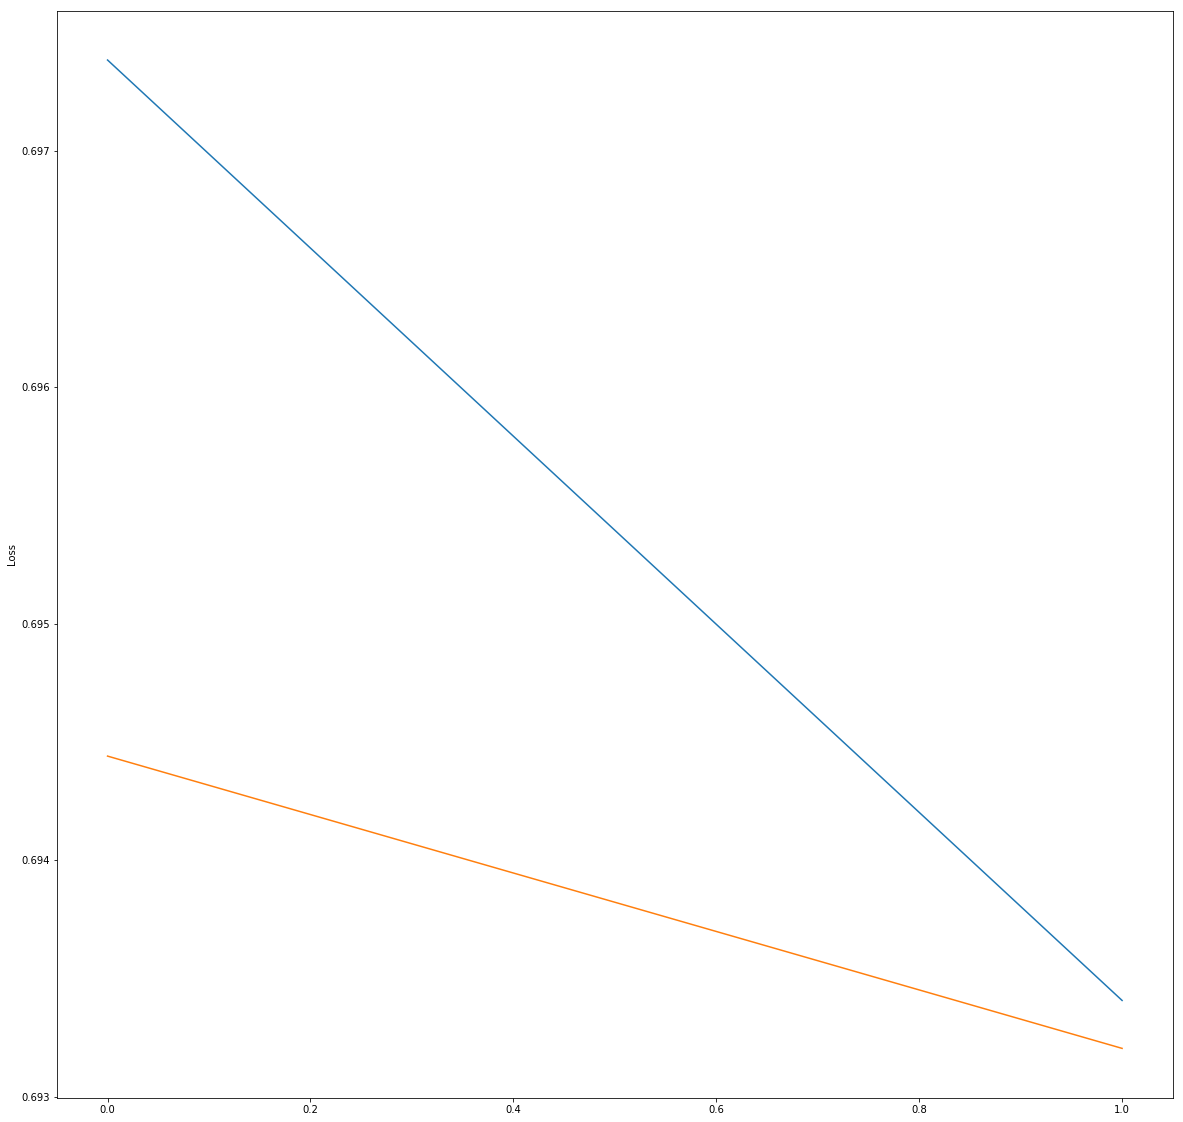

In [6]:
import matplotlib.pyplot as plt
plt.plot(trainGLoss)
plt.plot(trainDLoss)
plt.ylabel('Loss')
plt.show()

[2019-05-30 08:58:30,442] Loading from directory: ./data
[2019-05-30 08:58:30,447] Dataset Images: (7481, 375, 1242, 3)
[2019-05-30 08:58:30,448] Dataset Objects: (51865, 16)
[2019-05-30 08:58:30,449] Dataset Matricies: (7481, 3, 4)


[[ 4.2305698   0.289754   25.1446372 ]
 [-5.32773502  1.19631935 27.61763213]
 [ 3.69927431  1.14104303 41.7561358 ]
 [-7.86460333  0.71129485 33.35521117]
 [-7.11496451  1.399878   24.23695238]
 [-5.82594436  1.04726654 38.93161188]
 [-5.13596301  1.54925125 42.35522805]
 [ 1.27963894  0.50890251 16.25668994]]
[[1.88007497e+00 1.48000000e+00 2.89589606e+01]
 [1.92002061e+00 1.48000000e+00 3.26587450e+01]
 [3.51997939e+00 1.48000000e+00 2.89412550e+01]
 [3.55992503e+00 1.48000000e+00 3.26410394e+01]
 [1.88007497e+00 3.00000000e-02 2.89589606e+01]
 [1.92002061e+00 3.00000000e-02 3.26587450e+01]
 [3.51997939e+00 3.00000000e-02 2.89412550e+01]
 [3.55992503e+00 3.00000000e-02 3.26410394e+01]]


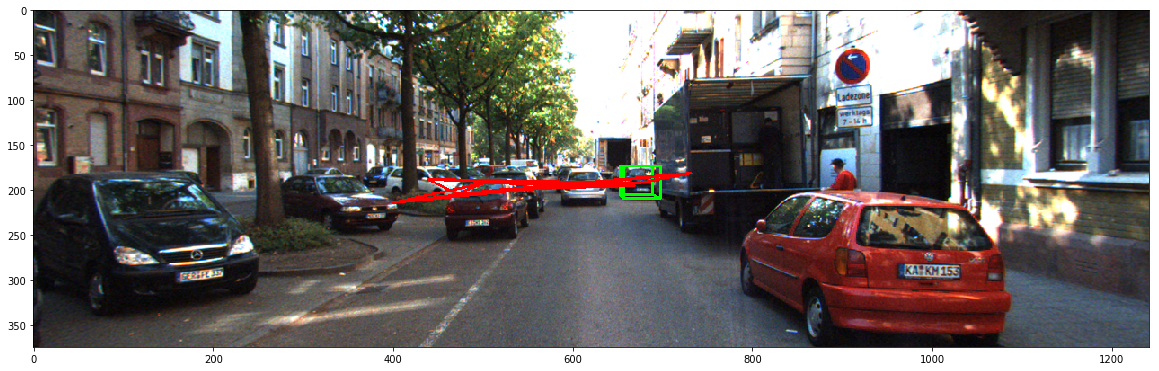

In [7]:
from KITTICat.KITTIData import *
import matplotlib.pyplot as plt

import pathlib

bindex = 10

data = KITTIData()
data.loadFrom(pathlib.Path('.'))

netout = result[bindex].copy().reshape(8, 3)

mean = traingen.pointMean
std = traingen.pointStd

corrected = (netout * std) + mean
print(corrected)
corrected =  np.concatenate([corrected, np.ones((corrected.shape[0],1),dtype=corrected.dtype)], axis=1)
gt = batch['points'][bindex].copy()
print(gt)
gt =  np.concatenate([gt, np.ones((gt.shape[0],1),dtype=gt.dtype)], axis=1)

imgid = int(batch['imageids'][bindex])
img = data.images[imgid].copy()
matrix = data.matricies[imgid]

proj = np.matmul(gt, matrix.T)
coords = proj[:, 0:2] / proj[:, 2:3]

gt = [tuple(c) for c in coords.astype(int)]

proj = np.matmul(corrected, matrix.T)
coords = proj[:, 0:2] / proj[:, 2:3]
corrected = [tuple(c) for c in coords.astype(int)]

boxEdges = [[0,1], [0,2], [1,3], [2,3], [0,4], [4,5], [1,5], [4,6], [2,6], [6,7], [3,7], [5,7]]
for pointset, colour in [(gt, (0, 255, 0)), (corrected, (0, 0, 255))]:
    for edge in boxEdges:
        cv2.line(img, pointset[edge[0]], pointset[edge[1]], colour, 2)
    
    
    
# img = o.render(data.images[imgid], data.matricies[imgid])
# img = generated.render(img, data.matricies[imgid])


plt.rcParams["figure.figsize"]=20,20
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
